# Predicting Pet Insurance Claims - Pre-processing and Initial Modeling
## 1 Introduction
### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future.

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in dollars) a given policy holder will claim for during the second year of their policy.

### 1.3 Notebook Goals
* Split data into Train and Test sets
* Complete any remaining feature engineering
* Pre-process the data to prepare for modeling
* Create and assess initial models

## 2 Setup
### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import __version__ as sklearn_version

import datetime
import os
import pickle
from library.sb_utils import save_file

### 2.2 Data Load and Preview
At the end of exploratory data analysis, we had an updated data file for our pets data containing all pet records. As a quick review, here's a summary:
* Shape - Our clean dataframe is 50000 rows with each row corresponding to a single pet.
* Basic Info - For each pet, we have some basic info including species, breed, and age at time of enrollment.
* YoungAge - Designation for pets who enrolled at a very young age (< 7 weeks)
* Policy Info - We also have policy-level info for each pet including the monthly premium and deductible amount for claims.
* Claims Data - We also have claims data for each pet covering the first two policy years including:
* Number of claims per year and total (years 1 and 2 combined)
* Average claim amount per year and total (years 1 and 2 combined)
* Amount of claims per year and total (years 1 and 2 combined)

Let's load in the data and preview.

In [2]:
pets = pd.read_csv('../data/pets.csv', index_col=0)
pets.head(8).T

,0,1,2,3,4,5,6,7
PetId,0,1,2,3,4,5,6,7
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat,Dog
Breed,Schnauzer Standard,Yorkiepoo,Mixed Breed Medium,Labrador Retriever,French Bulldog,Shih Tzu,American Shorthair,Boxer
Premium,84.54,50.33,74.0,57.54,60.69,43.53,47.4,75.14
Deductible,200,500,500,500,700,700,250,700
AgeYr1,3,0,0,0,0,2,0,5
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25,2665.67,0.0,2873.47
AmtClaimsYr2,1242.0,0.0,1187.68,0.0,168.75,0.0,811.38,2497.03
AvgClaimsYr1,0.0,0.0,213.543333,0.0,801.361111,296.185556,0.0,410.495714


### 2.3 Initial Plan for Pre-processing and Feature Engineering
Our primary goal for pre-processing will be to prepare our data for modeling. At a our minimum, this will include scaling and/or normalizing our features against one another, generating any required dummy values for categorical columns and splitting our data into our train and test sets.

**Train / Test Prep**
* Drop all 'Yr2' and 'Total' columns except AmtClaimsYr2 (our target) as this is data we would not have available for making predictions
* Split our data into training and test sets

**Feature Engineering** 
* Premium and Deductible - Roll these features up to the breed level to smooth out some of the variability between pets that are in essence, identical
* Breed - Employ a method to reduce the number of unique values
* Breed statistics - Add features to incorporate breed-related statistics into pets data
* PetAge - Consider adding a new features factoring in age (e.g., average claim amount in year 1, average total claims in year 1 - by age grouping)
* AmtClaimsYr1 and AvgClaimsYr1 - consider rolling these up into one feature or rolling these up by breed
* NumClaimsYr1 - Consider dropping this column or rolling up by breed; Could also be converted to binary (claims and no-claims)

**Pre-processing**
* Species - Convert to binary
* Breed - Create dummy variables for the remaining breeds
* All columns - Scale or normalize any columns not already converted to binary or dummy variables


## 3 Split the Data
As a first step, we'll take care of the train/test split to prevent any data leakage. Before we split the data, we need to drop some of the features that won't be part of our model. 

In addition, we observed in data wrangling and EDA, that there are a wide variety of breeds in our data. If we want to maintain a balanced distribution of breeds after our split, we'll need to use *stratify* to achieve this. Stratify won't work with our current data since we have some breeds with only 1 pet and stratify requires a minimum of 2 in each category.

To work around this, we can take a few steps to reduce the number of unique values for 'Breed'. In doing so, we can ensure a minimum number of pets in each category. 

### 3.1 Drop Unnecessary or Unusable Features 
Before we move on with preprocessing, we need to drop some features from the data that are either unnecessary or unusable in our predictive model. These include:
* **Year 2 Claims Data** - Using year 2 claims data to predict year 2 claims amount would be unfair and introduce data leakage into our model. The result would be that we would end up with a model that is overfit to our current dataset and would likely not generalize well with new data.
* **Premium and Deductible** - Premium and deductible amounts are set by the insurance company and are not directly related to the number or amount of claims for any specific pet.
* **PetId** - An arbitrary ID number that is meaningless when predicting insurance claims amounts.

In [3]:
# Drop features that won't be part of the model
drop_cols = ['PetId', 'Premium', 'Deductible', 'AvgClaimsYr2', 'NumClaimsYr2', 'AmtClaimsTotal', 'AvgClaimsTotal',
             'NumClaimsTotal', 'YrsWithClaims']
pets.drop(columns=drop_cols, inplace=True)

### 3.2 Reduce the Number of Unique Breeds
To reduce the number of unique breeds in the data, we'll follow the steps below:

1. Set threshold and save a list of breeds with counts greater or equal to the threshold
2. Write a function to update the breed for a row based on whether or not it exists in the list from step 1
3. Create a copy of our original df and apply the function
4. Print out the before and after numbers for our count of unique breeds

As part of step 2 above, we'll update the breed name for breeds with a low pet count to group them together in an *Other* category. To ensure we don't lose any species-specific information, we'll create two versions of *Other*, 'Other Cat' and 'Other Dog'. 

In [4]:
breeds = pd.read_csv('../data/breeds.csv', index_col=0)
breeds.head(10).T

,0,1,2,3,4,5,6,7,8,9
Breed,Abyssinian,Affenpinscher,Afghan Hound,Aidi,Airedale Terrier,Akbash Dog,Akita,Alaskan Klee Kai,Alaskan Malamute,American Bandogge Mastiff
Species,Cat,Dog,Dog,Dog,Dog,Dog,Dog,Dog,Dog,Dog
PetCount,24,3,10,2,41,1,49,30,64,1
AvgTotalClaims,1462.780417,1746.19,645.543,0.0,1338.705366,11383.6,1217.91102,1510.666333,3096.346719,2295.07
AvgNumClaims,4.25,1.333333,2.5,0.0,2.097561,23.0,3.591837,3.166667,3.765625,8.0
WeightedTotalClaims,35106.73,5238.57,6455.43,0.0,54886.92,11383.6,59677.64,45319.99,198166.19,2295.07
WeightedNumClaims,102.0,4.0,25.0,0.0,86.0,23.0,176.0,95.0,241.0,8.0


In [5]:
# Set threshold
threshold = 100

# Preserve list of Breeds with count greater equal to the threshold
breeds_list = breeds[breeds.PetCount >= threshold].Breed.tolist()

# Create function to update breed column based on threshold
def update_breed(row):
    if (row["Breed"] in breeds_list):
        return row["Breed"]
    else:
        if (row["Species"] == 'Cat'):
            return 'Other Cat'
        else:
            return 'Other Dog'

# Print number of unique breeds before update
print("Number of unique breeds before: " + str(pets.Breed.nunique()))

# Apply function to update Breed
pets["Breed"] = pets.apply(update_breed, axis=1)
print("Number of unique breeds after: " + str(pets.Breed.nunique()))

Number of unique breeds before: 373
Number of unique breeds after: 79


### 3.3 Split Data into Train and Test

In [6]:
# Split out target and features
y = pets["AmtClaimsYr2"].values
X = pets.drop(columns="AmtClaimsYr2")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=pets['Breed'], random_state=23)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 7)
(10000, 7)
(40000,)
(10000,)


## 4 Feature Engineering
Now that we've split the data into train and test sets, we can proceed with feature engineering without worrying about data leakage. As a next step, let's replace our **breeds** dataframe (which was based on the entire dataset) with an updated version based on our training dataset. Then we can pull in some of the summary statistics as new features.

* Breed statistics - Add features to incorporate breed-related statistics into pets data
* PetAge - Add features factoring in age (e.g., average claim amount in year 1, average total claims in year 1 - by age grouping, etc.)

### 4.1 Breed Statistics
After we create our new dataframe grouped by breed, we'll write a function to pull the summary statistics into our training data. 

In [8]:
# Group pets by breed and aggregate data
breeds = X_train.groupby(by=['Breed', 'Species']).agg({'Breed': ['count'],
                                                       'AmtClaimsYr1': ['mean'],
                                                       'NumClaimsYr1': ['mean'],
                                                       'AvgClaimsYr1': ['mean']}).reset_index()
breeds.columns = ['Breed', 'Species', 'PetCount', 'BreedAvgTotalClaims', 'BreedAvgNumClaims',
                  'BreedAvgClaimAmt']
breeds.head(10).T

,0,1,2,3,4,5,6,7,8,9
Breed,American Pitbull Terrier,American Shorthair,American Staffordshire Terrier,Aussiedoodle,Australian Labradoodle,Australian Shepherd,Beagle,Bengal,Bernedoodle,Bernese Mountain Dog
Species,Dog,Cat,Dog,Dog,Dog,Dog,Dog,Cat,Dog,Dog
PetCount,270,322,86,83,502,380,199,117,232,255
BreedAvgTotalClaims,1341.011852,460.591149,1056.347907,451.177711,594.123048,558.921737,1047.211508,564.791709,846.949224,1509.175333
BreedAvgNumClaims,2.107407,0.84472,1.616279,1.216867,1.848606,1.097368,2.045226,0.846154,2.431034,2.552941
BreedAvgClaimAmt,393.4894,170.55514,249.675607,143.48262,155.185672,200.744467,245.716931,165.485075,205.416341,315.759532


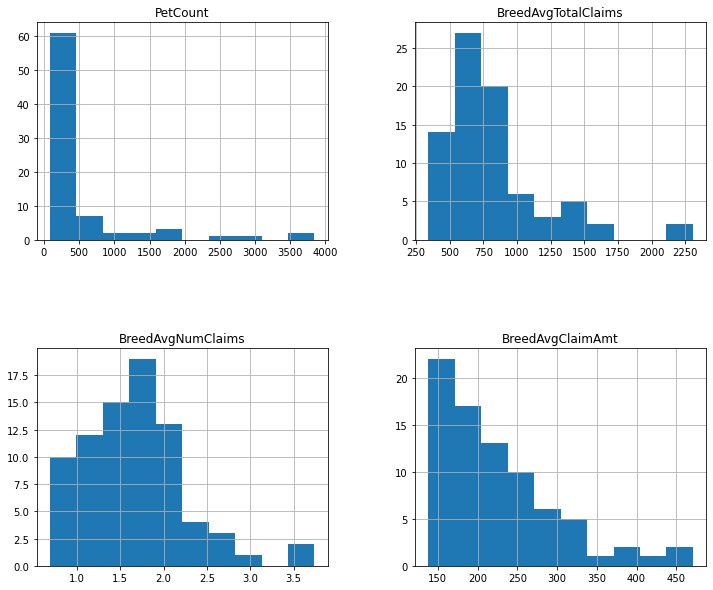

In [9]:
# Preview the distributions of each of our numeric features
breeds.hist(figsize=(12,10))
plt.subplots_adjust(hspace=0.5)
plt.show()

As we can see from the plots above, all of our breed-related features appear to be right-tailed in their distributions. This could impact the accuracy of our models later, and especially any that are regression-based. Given this, it might make sense to include at least one model in our evaluation that isn't as sensitive to skewness of this kind such as a Decision Tree. For now though, we can pull these new features into our dataframe and continue on to doing something similar for pet age.

In [10]:
# Create function to pull breed statistics into pets dataframe
def add_breed_stats(df):
    features = ['Breed', 'BreedAvgTotalClaims', 'BreedAvgNumClaims', 'BreedAvgClaimAmt']
    breed_stats = breeds.copy()[features]
    df = pd.merge(df, breed_stats, how='left', on='Breed')
    return df

In [11]:
# Apply function to training and test data & preview result
X_train = add_breed_stats(X_train)
X_test = add_breed_stats(X_test)

X_train.head(8).T

,0,1,2,3,4,5,6,7
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat,Dog
Breed,Mixed Breed Small,Labradoodle,Goldendoodle,Goldendoodle,Mixed Breed Small,Mixed Breed Large,Domestic Shorthair,Bernese Mountain Dog
AgeYr1,3,0,0,1,2,0,6,6
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,76.25,0.0,6010.88,303.15,0.0,701.6,431.57,0.0
AvgClaimsYr1,76.25,0.0,546.443636,151.575,0.0,701.6,215.785,0.0
NumClaimsYr1,1,0,11,2,0,1,2,0
BreedAvgTotalClaims,663.502526,540.515378,705.72864,705.72864,663.502526,925.434405,395.718466,1509.175333
BreedAvgNumClaims,1.491045,1.627294,1.766242,1.766242,1.491045,1.875611,0.871485,2.552941
BreedAvgClaimAmt,196.601991,159.645266,198.844913,198.844913,196.601991,240.294459,137.970879,315.759532


In [12]:
# Check for null values
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              40000 non-null  object 
 1   Breed                40000 non-null  object 
 2   AgeYr1               40000 non-null  int64  
 3   YoungAge             40000 non-null  int64  
 4   AmtClaimsYr1         40000 non-null  float64
 5   AvgClaimsYr1         40000 non-null  float64
 6   NumClaimsYr1         40000 non-null  int64  
 7   BreedAvgTotalClaims  40000 non-null  float64
 8   BreedAvgNumClaims    40000 non-null  float64
 9   BreedAvgClaimAmt     40000 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 3.4+ MB


In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              10000 non-null  object 
 1   Breed                10000 non-null  object 
 2   AgeYr1               10000 non-null  int64  
 3   YoungAge             10000 non-null  int64  
 4   AmtClaimsYr1         10000 non-null  float64
 5   AvgClaimsYr1         10000 non-null  float64
 6   NumClaimsYr1         10000 non-null  int64  
 7   BreedAvgTotalClaims  10000 non-null  float64
 8   BreedAvgNumClaims    10000 non-null  float64
 9   BreedAvgClaimAmt     10000 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 859.4+ KB


So after pulling in our breed stats, we can see that we don't have any missing values in our data. Before we move on to look at Pet Age statistics, we'll drop the 'Breed' column. We have a decent rollup of breed-related statistics which should hopefully be enough to encode any interesting patterns related to breed. In addition, this will ultimately help to reduce the dimensionality of our data significantly since we won't have to one-hot-encode 79 unique breed labels. 

In [14]:
X_train.drop(columns=['Breed'], inplace=True)
X_test.drop(columns=['Breed'], inplace=True)

### 4.2 Pet Age
Similar to breed, we would expect a wide range of vairiability in our claims data on a per-pet basis at each age level. However, averaging the claims data per age could help to offset some of that variability we see for individual pets. 

We'll start by grouping our data based on pet age and species.

In [15]:
# Group pets by age at enrollment and aggregate data
pets_by_age = X_train.groupby(by=["AgeYr1", "Species"]).agg({'AgeYr1': ['count'],
                                                             'AmtClaimsYr1': ['mean'],
                                                             'NumClaimsYr1': ['mean'],
                                                             'AvgClaimsYr1': ['mean']}).reset_index()
pets_by_age.columns = ['AgeYr1', 'Species', 'PetCount', 'AgeYr1AvgTotalClaims', 'AgeYr1AvgNumClaims',
                       'AgeYr1AvgClaimAmt']
pets_by_age.head(10).T

,0,1,2,3,4,5,6,7,8,9
AgeYr1,0,0,1,1,2,2,3,3,4,4
Species,Cat,Dog,Cat,Dog,Cat,Dog,Cat,Dog,Cat,Dog
PetCount,3137,22191,752,3087,577,2092,403,1423,321,1118
AgeYr1AvgTotalClaims,432.162369,902.942389,400.833989,699.071121,323.859775,619.496248,251.496303,722.652663,519.121308,723.072558
AgeYr1AvgNumClaims,0.985336,2.002704,0.742021,1.359896,0.570191,1.243786,0.565757,1.275474,0.943925,1.211986
AgeYr1AvgClaimAmt,136.041435,234.275301,157.715909,212.218786,136.636061,198.114908,108.815545,218.098714,185.830467,221.268973


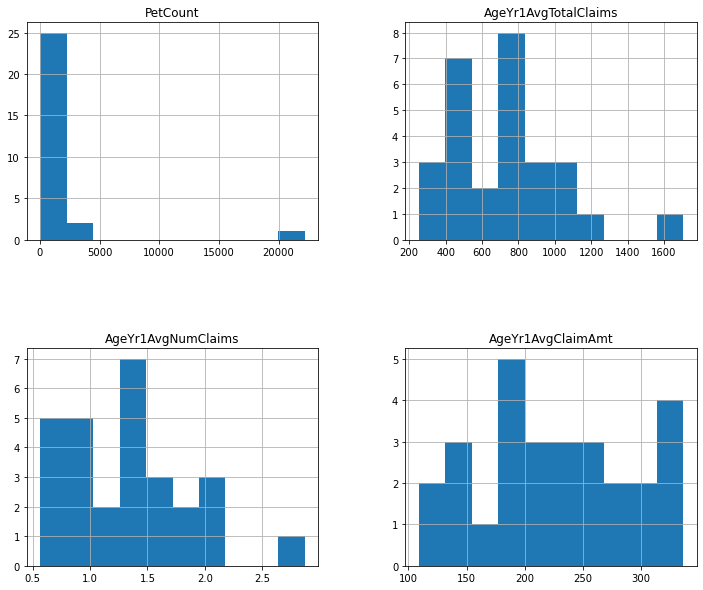

In [16]:
# Create a df with only the new columns created
age_subset = pets_by_age[['PetCount', 'AgeYr1AvgTotalClaims', 'AgeYr1AvgNumClaims',
                          'AgeYr1AvgClaimAmt']]

# Preview the distributions of each of our numeric features
age_subset.hist(figsize=(12,10))
plt.subplots_adjust(hspace=0.5)
plt.show()

Similar to the breed data, we see non-regular distributions for all of our age related features. In this case, there isn't the same consistent right-skewness. Instead, we are seeing more of a multi-modal distribution for 3 of the 4 new features. As mentioned above, this irregularity will likely have an impact on the accuracy of any regression-based modeling.

In [17]:
# Create function to pull age statistics into pets dataframe
def add_age_stats(df):
    features = ['AgeYr1', 'Species', 'AgeYr1AvgTotalClaims', 'AgeYr1AvgNumClaims', 'AgeYr1AvgClaimAmt']
    age_stats = pets_by_age.copy()[features]
    df = pd.merge(df, age_stats, how='left', on=(['AgeYr1', 'Species']))
    return df

In [18]:
# Apply function to training and test data & preview result
X_train = add_age_stats(X_train)
X_test = add_age_stats(X_test)

X_train.head(8).T

,0,1,2,3,4,5,6,7
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat,Dog
AgeYr1,3,0,0,1,2,0,6,6
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,76.25,0.0,6010.88,303.15,0.0,701.6,431.57,0.0
AvgClaimsYr1,76.25,0.0,546.443636,151.575,0.0,701.6,215.785,0.0
NumClaimsYr1,1,0,11,2,0,1,2,0
BreedAvgTotalClaims,663.502526,540.515378,705.72864,705.72864,663.502526,925.434405,395.718466,1509.175333
BreedAvgNumClaims,1.491045,1.627294,1.766242,1.766242,1.491045,1.875611,0.871485,2.552941
BreedAvgClaimAmt,196.601991,159.645266,198.844913,198.844913,196.601991,240.294459,137.970879,315.759532
AgeYr1AvgTotalClaims,722.652663,902.942389,902.942389,699.071121,619.496248,902.942389,449.891932,904.086963


## 5. Data Preprocessing

Now that we've completed our feature engineering, let's take a look at our data and complete any additional pre-processing on categorical features before we move on to model creation. 

Let's review the dtypes in our dataset.

In [19]:
print(X_train.dtypes.value_counts())
obj_cols = X_train.select_dtypes(include=['object']).columns.to_list()
print("\nRemaining categorical columns: " + str(obj_cols))

float64    8
int64      3
object     1
dtype: int64

Remaining categorical columns: ['Species']


We still have one object column to deal with before we can move on to modeling (Species). As observed earlier, species contains two possible values - Cat and Dog. We can create a preprocessor to use OneHotEncoder as part of our pipeline and use the (drop='if_binary') argument to utilize OneHotEncoder for our binary species data.

In [20]:
# Create a preprocessor to encode the categorical columns
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['Species']),
    remainder='passthrough'
)

## 6 Baseline Models
Next we'll make a pipeline including the preprocessor we created above as one of the pipeline steps. For our baseline model review, let's start by looking at a dummy regressor using the mean of our data. Then we can compare the performance with a simple linear regression model. This should provide us with a good starting point to build on with more sophisticated modeling techniques.

In terms of scoring, we'll look at **mean absolute error** since this will render scores in the units of our target variable (i.e., USD). This will simplifiy model comparison by making the results more intuitive.

To begin, we'll make the pipeline including the following steps:
* preprocessor - created above to replace our categorical variables
* regressor - to allow for passing in different regressor functions

We will also create a scorer to calculate the mean absolute error for our cross validation result.

In [21]:
# Create scoring function
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

### 6.1 Dummy Regressor

In [22]:
# Dummy regressor
regressor = DummyRegressor(strategy = 'mean')

# Make pipeline, cross validate and get results
pipe = make_pipeline(preprocessor, regressor)
cv_results = cross_validate(pipe, X_train, y_train, scoring=mae_scorer, cv=5)
-1* (round(np.mean(cv_results['test_score']), 2))

1020.42

Looking at the results of the dummy regressor, we see that just using the mean value for our target leaves us with an mae of over 1000 which in this case, would translate to about \$1000. Let's see if we can improve upon that by using a simple linear regression model.

### 6.2 Simple Linear Regression Model

In [23]:
# Linear regression
regressor = LinearRegression()

# Make pipeline, cross validate and get results
pipe = make_pipeline(preprocessor, regressor)
cv_results = cross_validate(pipe, X_train, y_train, scoring=mae_scorer, cv=5)
-1 * (round(np.mean(cv_results['test_score']), 2))

930.38

Nice... by simply utilizing a basic linear regression model with no tuning, we've already improved upon simply using the mean value for our predictions. The mae is still relatively high, but if we were to stop here, this would translate to an improvement of **~\$90**, or roughly **9% better than baseline**.

As a next step, let's see if we can improve on our results by adding feature selection to our model. To do this, we'll use the 'SelectKBest' method to help us determine the best number of features for our model. 

### 6.3 Linear Regression with Feature Selection

In [24]:
# Select K best features (default)
select_k_best = SelectKBest(f_regression)

# Make pipeline, cross validate and get results
pipe = make_pipeline(preprocessor, select_k_best, regressor)
cv_results = cross_validate(pipe, X_train, y_train, scoring=mae_scorer, cv=5)
-1 * round(np.mean(cv_results['test_score']), 2)

930.35

As seen above, using the default value for k (i.e., 10) shows only a tiny improvement over our linear regression model without feature selection. Given that our data includes 12 features, it's possible 10 is not the best value for k though. 

As a next step, let's cycle through a few different possible k values and then plot the results to see how the scores change with each value of k. We'll start with a broad range of k values to get a feel for the point at which adding more features no longer improves model performance. Then we can drill in to try and pin point the best k value.

#### 6.3.1 Evaluate k Values - Broad Range

In [28]:
# Create list of potential k values
k = [k for k in range(1, 13, 1)]

# Create grid parameters for our grid search
grid_params = {'selectkbest__k': k}

# Create our grid search model
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, scoring=mae_scorer, cv=5, n_jobs=-1)

# Fit the training data
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Species'])])),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f5f35f22940>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

Next, we'll create a function to plot the results.

In [29]:
# Create function to get cv scores and plot results
def get_score_and_plot(cv_results, best_params):
    
    # Print best 'k'
    print(lr_grid_cv.best_params_)
    
    # Get cv_score mean, std and k value
    score_mean = [mean for mean in cv_results['mean_test_score']]
    score_std = [std for std in cv_results['std_test_score']]
    cv_k = [k for k in cv_results['param_selectkbest__k']]
    
    # Get best k and plot the results
    best_k = best_params['selectkbest__k']
    plt.subplots(figsize=(10, 5))
    plt.errorbar(cv_k, score_mean, yerr=score_std) 
    plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
    plt.xlabel('k')
    plt.ylabel('CV score (mae)')
    plt.title('Pipeline mean');
    

{'selectkbest__k': 9}


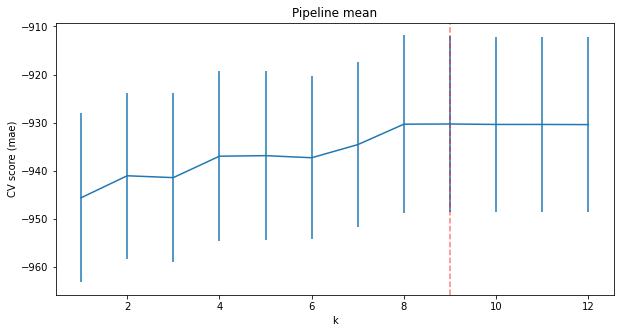

In [30]:
get_score_and_plot(lr_grid_cv.cv_results_, lr_grid_cv.best_params_)

Based on the above plot, it looks like the best value for k is actually 9, although the difference appears to be very slight from the range of 8-12.

#### 6.3.2 Review Best Features
Now that we have a value for our best k, we can use that value and the results from our cross validation above to pull a list of the most important features.

First, we'll select the features based on the best k along with the coefficient values for each. Then we'll get a list of feature names after our preprocessing step. Finally, we'll pull it all together into a format we can evaluate.

In [32]:
# Create a function to generate the list of best features
def get_best_features(lr_grid_cv, original_features, categorical_features):
    
    # Get the selected features using the best estimator
    selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

    # Get the coefs for the selected features
    coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_

    # Get the list of feature names after transformation
    trans_feats = list(lr_grid_cv.best_estimator_.named_steps.columntransformer.\
                               transformers_[0][1].get_feature_names(categorical_features))
    features = np.array(trans_feats + original_features) 
    
    # Print the list of the features in order of importance
    selected_features = features[selected]
    best_feats = pd.Series(coefs, index=selected_features).sort_values(ascending=False)
    
    return best_feats

In [33]:
# Generate a list of the best features and associated coefs based on best 'k' value
original_features = ['AgeYr1', 'YoungAge', 'AmtClaimsYr1', 'AvgClaimsYr1', 'NumClaimsYr1', 'BreedAvgTotalClaims',
                     'BreedAvgNumClaims', 'BreedAvgClaimAmt', 'AgeYr1AvgTotalClaims','AgeYr1AvgNumClaims',
                     'AgeYr1AvgClaimAmt']
categorical_features = ['Species']

get_best_features(lr_grid_cv, original_features, categorical_features)

NumClaimsYr1            108.715670
AgeYr1                   76.900192
BreedAvgClaimAmt          2.047266
AgeYr1AvgTotalClaims      0.276601
BreedAvgTotalClaims       0.140302
AmtClaimsYr1              0.126248
AvgClaimsYr1             -0.098201
AgeYr1AvgClaimAmt        -0.724293
BreedAvgNumClaims       -32.415727
dtype: float64

Looking at the list of the best features along with their coefficient values provides us with an idea of how much each feature is contributing to our overall model. In general, none of the selected features are suprising given that (other than AgeYr1), they are all related to claims in one way or another (i.e., number, amount, average) and our target is the year 2 claims amount.

That said, a couple of points do stand out:
* Two of the features - NumClaimsYr1 and AgeYr1 - appear to be significantly more important to the model than the rest of the features. It does seem logical that both of these features would make the list, but the extent to which they contribute to the model predictions over and above other features is tough to explain.
* Species doesn't even register on our list of important features. This is surprising given the discrepencies we observed in EDA between cats and dogs.

As a next step, let's see how our model performs if we limit it to the two most important features in our list above. Then, for the sake of curiousity, we can add in Species to see how this affects performance.

### 6.4 Simple Model with Two Best Features

In [34]:
# Create a new, simplified dataframe with the two best features and target
pets_new = pets[['NumClaimsYr1', 'AgeYr1', 'AmtClaimsYr2']]

# Split out target and features
y_new = pets_new["AmtClaimsYr2"].values
X_new = pets_new.drop(columns="AmtClaimsYr2")

# Split the data into train and test sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=23)

In [35]:
# Confirm the shape of train and test sets
print(X_train_new.shape)
print(X_test_new.shape)
print(y_train_new.shape)
print(y_test_new.shape)

(40000, 2)
(10000, 2)
(40000,)
(10000,)


In [36]:
# Instantiate a linear regression model
regressor = LinearRegression()

# Make pipeline, cross validate and print results
pipe = make_pipeline(regressor)
cv_results = cross_validate(pipe, X_train_new, y_train_new, scoring=mae_scorer, cv=5)
-1 * round(np.mean(cv_results['test_score']), 2)

926.37

# Add observations - slightly better with two best features

### 6.5 Simple Model with Two Best Features + Species

In [37]:
# Create a new, simplified dataframe with the two best features (plus Species) and target
pets_new = pets[['NumClaimsYr1', 'AgeYr1', 'Species', 'AmtClaimsYr2']]

# Split out target and features
y_new = pets_new["AmtClaimsYr2"].values
X_new = pets_new.drop(columns="AmtClaimsYr2")

# Split the data into train and test sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=23)

In [38]:
# Confirm the shape of train and test sets
print(X_train_new.shape)
print(X_test_new.shape)
print(y_train_new.shape)
print(y_test_new.shape)

(40000, 3)
(10000, 3)
(40000,)
(10000,)


In [39]:
# Create a preprocessor to encode the categorical columns
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['Species']),
    remainder='passthrough'
)

# Instantiate a linear regression model
regressor = LinearRegression()

# Make pipeline, cross validate and print results
pipe = make_pipeline(preprocessor, regressor)
cv_results = cross_validate(pipe, X_train_new, y_train_new, scoring=mae_scorer, cv=5)
-1 * round(np.mean(cv_results['test_score']), 2)

923.92

### Test with original dataframe prior to feature engineering

In [43]:
# Split out target and features
y_new = pets['AmtClaimsYr2'].values
X_new = pets.drop(columns=['AmtClaimsYr2', 'Breed'])

# Split the data into train and test sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=23)

In [44]:
# Confirm the shape of train and test sets
print(X_train_new.shape)
print(X_test_new.shape)
print(y_train_new.shape)
print(y_test_new.shape)

(40000, 6)
(10000, 6)
(40000,)
(10000,)


In [45]:
# Create a preprocessor to encode the categorical columns
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['Species']),
    remainder='passthrough'
)

# Instantiate a linear regression model
regressor = LinearRegression()

# Make pipeline, cross validate and print results
pipe = make_pipeline(preprocessor, regressor)
cv_results = cross_validate(pipe, X_train_new, y_train_new, scoring=mae_scorer, cv=5)
-1 * round(np.mean(cv_results['test_score']), 2)

920.29

# START HERE - 
* Add observations
    * by simplifying our model, we've actually been able to improve performance over and above our initial results.
* Next steps
    * Learning curve plot
    * Lasso alone, reduce to non-zero features, don't normalize, then with grid search for alpha
    * Random forest regression
    * Save best model
    * Summarize
    * Maybe, determine if I really need scorer and if not refactor

### Other Tests 

In [47]:
from sklearn.linear_model import Lasso

# Lasso regression
regressor = Lasso(alpha=0.1, normalize=True)

# Make pipeline and get results
pipe = make_pipeline(preprocessor, regressor)
cv_results = cross_validate(pipe, X_train_new, y_train_new, scoring=mae_scorer, cv=5)
-1 * round(np.mean(cv_results['test_score']), 2)

921.88

In [48]:
from sklearn.ensemble import RandomForestRegressor

# Random forest regression
regressor = RandomForestRegressor(n_estimators=10)

scaler = StandardScaler(with_mean=False)

# Make pipeline and get results
pipe = make_pipeline(preprocessor, scaler, regressor)
cv_results = cross_validate(pipe, X_train_new, y_train_new, scoring=mae_scorer, cv=5)
-1 * round(np.mean(cv_results['test_score']), 2)

1004.68

## 8 Save Model

In [ ]:
# # Store some basic information about the model
# best_model = rf_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

In [ ]:
# # save the model

# modelpath = '../models'
# save_file(best_model, 'ski_resort_pricing_model.pkl', modelpath)

## 8 Summary

TBD

In [ ]:
## Consider for next notebook

# y_pred = model.predict(X_train)

# mae = median_absolute_error(y_train, y_pred)
# y_pred = model.predict(X_test)
# mae = median_absolute_error(y_test, y_pred)
# fig, ax = plt.subplots(figsize=(5, 5))
# plt.scatter(y_test, y_pred)
# ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
# plt.title('Ridge model, small regularization')
# plt.ylabel('Model predictions')
# plt.xlabel('Truths')
# plt.xlim([0, 1500])
# _ = plt.ylim([0, 1500])

# Consider for next notebook
Random Forest Hyperparameter Tuning

In [ ]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', None]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Print the grid
# pprint(random_grid)

In [ ]:
# # Use the random grid to search for best hyperparameters
# # Create the base model to tune
# rf = RandomForestRegressor()

# # Random search of parameters, using 5 fold cross validation, 
# # search across 5 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
#                                n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [ ]:
# # View best performing parameter combination
# rf_random.best_params_

So even using the best random forest model, our performance is still looking slightly worse than with our linear model when looking at only the best k features. 